In [2]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
from matplotlib import gridspec
np.set_printoptions(precision=2, suppress=True)

%matplotlib inline

# Define linear program as a function of $P(Y)$, $\lambda$, and $\epsilon$

In [43]:
# Cardinality of X and Y
K = 6
# shape of the joint over counterfactuals
joint_shape = (K,K,K,K,2,2)
domain = [list(range(d)) for d in joint_shape]
def get_lp(pyagz,
           lamb,
           eps,
           err_const=True,
           mon_const=True,
           sym_const=True,
           pos_effect_of_treatment=True,
           pos_effect_of_truth=True):
    """
        Calculate bounds on the ATE in the IV model w/ measurement
        error (see Sec. 4 of the main paper). 
        
        Arguments:
        
        pyagz - (K,) numpy array: 
            P(Y,A|Z)
            
        lamb - float: 
            Slack on (A2).
            
        eps - float:
            Upper bound on the total proportion of errors. Only used 
            if err_const == True.
            
        err_const - bool:
            Include total error constraint (A0).
            
        mon_const - bool:
            Include monotonicity constraint (A2).
            
        sym_const - bool:
            Include symmetry constraint (A3).
            
        pos_effect_of_treatment - bool:
            Include positive effect of treatment on truth constraint (A5).
            
        pos_effect_of_truth - bool:
            Include positive effect of truth on proxy constraint (A6).
        
    """
    
    # Create objective function weights
    c = np.zeros(joint_shape)
    for x0,x1,y0,y1,a0,a1 in it.product(*domain):
        c[x0,x1,y0,y1,a0,a1] = x1 - x0

    c = c.flatten()
    
    # Equality constraints
    A_eq = []
    b_eq = []
    
    # Inequality (upper bound) constraints
    A_ub = []
    b_ub = []
    
    # observed data constraint
    # \sum_{x,x',y',a'} \phi_{xx'yy'0a'} = P(Y=y,A=0|Z=0)
    for y in range(K):
        for a in range(2):
            for z in range(2):
                a_eq = np.zeros(joint_shape)
                if a == 0 and z == 0:
                    a_eq[:,:,y,:,a,:] = 1
                elif a == 0 and z == 1:
                    a_eq[:,:,y,:,:,a] = 1
                elif a == 1 and z == 0:
                    a_eq[:,:,:,y,a,:] = 1
                elif a == 1 and z == 1:
                    a_eq[:,:,:,y,:,a] = 1
                
                A_eq.append(a_eq.flatten())
                b_eq.append(pyagz[y,a,z])
                
    A_eq = A_eq[:-1]
    b_eq = b_eq[:-1]
        
        
    # Exclusion restriction
    a = np.zeros(joint_shape)
    for x0,x1,y0,y1,a0,a1 in it.product(*domain):
        if x0 == x1 and y0 != y1: 
            a[x0,x1,y0,y1,a0,a1] = 1
    A_eq.append(a.flatten())
    b_eq.append(0)
    
    # Positive effect of treatment on truth
    if pos_effect_of_truth:
        a = np.zeros(joint_shape)
        for x0,x1,y0,y1,a0,a1 in it.product(*domain):     
            if (x0 >= x1 and y0 < y1) or (x0 <= x1 and y0 > y1):
                a[x0,x1,y0,y1,a0,a1] = 1
                
        A_eq.append(a.flatten())
        b_eq.append(0)
        
    # Positive effect of truth on proxy
    if pos_effect_of_treatment:
        a = np.zeros(joint_shape)
        for x0 in range(K):
            for x1 in range(K):
                if x1 > x0:
                    a[x0,x1,:,:] = 1
        A_eq.append(a.flatten())
        b_eq.append(0)
    
    
    # bound on proportion of errors
    # \sum_{x,y: |x-y| > 2} \phi_{xy} <= \epsilon
    if err_const:
        a = np.zeros(joint_shape)
        for x0 in range(K):
            for y0 in range(K):
                if np.abs(x0-y0) > 2:
                    a[x0,:,y0,:,:,:] = 1
        A_ub.append(a.flatten())
        b_ub.append(eps)
        
        a = np.zeros(joint_shape)
        for x1 in range(K):
            for y1 in range(K):
                if np.abs(x1-y1) > 2:
                    a[:,x1,:,y1,:,:] = 1
        A_ub.append(a.flatten())
        b_ub.append(eps)
    
    # monotonicity constraint
    # \phi_{xy} - \phi_{xy'} <= 0 for all |x - y| > |x - y'|
    if mon_const:
        for x in range(K):
            for y in range(K):
                for yp in range(K):
                    if np.abs(x-y) < np.abs(x-yp):
                        a = np.zeros(joint_shape)
                        a[x,:,y,:]  = -1
                        a[x,:,yp,:] = 1
                        A_ub.append(a.flatten())
                        b_ub.append(0)
                        
                        a = np.zeros(joint_shape)
                        a[:,x,:,y]  = -1
                        a[:,x,:,yp] = 1
                        A_ub.append(a.flatten())
                        b_ub.append(0)
                    
    # approximate symmetry constraint
    # |\phi_{xy} - \phi_{xy'}| <= \lambda for all |x - y| = |x - y'|
    if sym_const:
        for x in range(K):
            for y in range(K):
                for yp in range(K):
                    if np.abs(x-y) == np.abs(x-yp) and y != yp:
                        a = np.zeros(joint_shape)
                        a[x,:,y,:]  = 1
                        a[x,:,yp,:] = -1
                        A_ub.append(a.flatten())
                        b_ub.append(lamb)

                        a = np.zeros(joint_shape)
                        a[x,:,y,:]  = -1
                        a[x,:,yp,:] = 1
                        A_ub.append(a.flatten())
                        b_ub.append(lamb)
                        
                        a = np.zeros(joint_shape)
                        a[:,x,:,y]  = 1
                        a[:,x,:,yp] = -1
                        A_ub.append(a.flatten())
                        b_ub.append(lamb)

                        a = np.zeros(joint_shape)
                        a[:,x,:,y]  = -1
                        a[:,x,:,yp] = 1
                        A_ub.append(a.flatten())
                        b_ub.append(lamb)
                    
    # non-negativity
    bounds = []
    for x in it.product(*domain):
        bounds.append((0,1))

    A_eq = np.array(A_eq)
    b_eq = np.array(b_eq)
    
    if len(A_ub) == 0:
        A_ub = None
        b_ub = None
    else:
        A_ub = np.array(A_ub)
        b_ub = np.array(b_ub)
    
    return c,A_eq,b_eq,A_ub,b_ub,bounds
    
def get_bounds(pyagz,
               lamb,
               eps,
               err_const=True,
               mon_const=True,
               sym_const=True,
               pos_effect_of_treatment=True,
               pos_effect_of_truth=True):
    
    # Get LP params
    c,A_eq,b_eq,A_ub,b_ub,bounds = get_lp(pyagz,
                                          lamb,
                                          eps,
                                          err_const,
                                          mon_const,
                                          sym_const,
                                          pos_effect_of_treatment,
                                          pos_effect_of_truth)
    

    # Solve for lower bound
    lb_res = linprog(c,A_eq=A_eq,b_eq=b_eq,A_ub=A_ub,b_ub=b_ub,bounds=bounds)
    
    # Solve for upper bound
    ub_res = linprog(-c,A_eq=A_eq,b_eq=b_eq,A_ub=A_ub,b_ub=b_ub,bounds=bounds)
    
    return lb_res.fun,-ub_res.fun

# Expected value of X with two noisy proxies

In [44]:
# P(Z)
pz = np.ones(2)/2

# P(A|Z)
pagz = np.array([[0.8,0.2],
                 [0.2,0.8]])

# P(Y|A,Z)
pygaz = np.array([[[4.,8.,16.,32.,16.,8.],
                   [16.,32.,16.,8.,4.,2.]],
                  [[8.,16.,32.,16.,8.,4.],
                   [32.,16.,8.,4.,2.,1.]]])

pygaz = np.transpose(pygaz,(2,1,0))
                  
pygaz /= pygaz.sum(0).reshape((1,2,2))

# P(Y,A|Z)
pyagz = pygaz * pagz.reshape((1,2,2))

In [45]:
# Calculate bounds (may take a few of minutes)
bounds = np.zeros((4,2))

# (A4)
bounds[0] = np.array(get_bounds(pyagz,0.01,0.01,False,False,False,False,False))
# (A4) + (A5)
bounds[1] = np.array(get_bounds(pyagz,0.01,0.01,False,False,False,False,True))
# (A4) + (A5) + (A6)
bounds[2] = np.array(get_bounds(pyagz,0.01,0.01,False,False,False,True,True))
# (A4) + (A5) + (A6) + (A0) + (A2) + (A3)
bounds[3] = np.array(get_bounds(pyagz,0.01,0.01,True,True,True,True,True))

In [10]:
# Save the bounds
import pickle as pk
with open("../output/iv_bounds.pkl",'wb') as f:
    pk.dump(bounds,f)

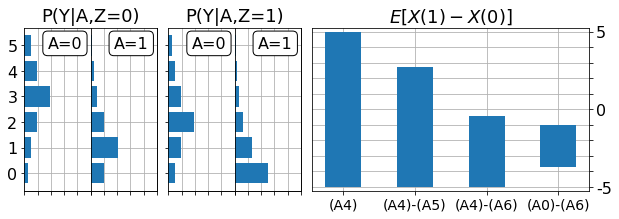

In [46]:
fig = plt.figure(figsize=(8,3),constrained_layout=False)

for z in range(2):
    if z == 0:
        spec = fig.add_gridspec(nrows=1,ncols=2,left=0.01,right=0.24,wspace=0.0)
    else:
        spec = fig.add_gridspec(nrows=1,ncols=2,left=0.26,right=0.49,wspace=0.0)
    
    # Plot dist titles
    ax2 = fig.add_subplot(spec[:])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title(f"P(Y|A,Z={z})",fontsize=18)
        
    # Plot P(Y|A,Z) for each A and Z
    for a in range(2):
        i = 2*z + a
        ax = fig.add_subplot(spec[a])
        plt.barh(range(K),pygaz[:,a,z])
        ylim = plt.gca().get_ylim()
        plt.xticks(np.arange(0,1.1,0.2),6*[""],fontsize=15)
        if z==0 and a == 0:
            plt.yticks(fontsize=16)
        else:
            plt.yticks(range(6),6*[""],fontsize=14)
            if a == 1: 
                ax.tick_params(axis='y',length=0.0)
        plt.grid()
        props = dict(boxstyle='round', facecolor='white',alpha=1.0)
        ax.text(0.35,0.95, f"A={a}", transform=ax.transAxes, fontsize=16,
                verticalalignment='top',bbox=props)
        ax.set_axisbelow(True)
    
    
# Plot bounds
spec = fig.add_gridspec(nrows=1,ncols=1,left=0.51,right=0.99)
ax2 = fig.add_subplot(spec[0])
plt.bar(range(4),bounds[:,1]-bounds[:,0],bottom=bounds[:,0],width=0.5)
plt.ylim([-5.25,5.25])
plt.grid()
ax2.set_axisbelow(True)
plt.xticks([0,1,2,3],["(A4)","(A4)-(A5)","(A4)-(A6)","(A0)-(A6)"],fontsize=14)
plt.yticks(range(-5,6),["-5"] + 4*[""] + ["0"] + 4*[""] + ["5"],fontsize=16)
ax2.yaxis.tick_right()

plt.title(r"$E[X(1) - X(0)]$",fontsize=18)

plt.savefig(f"../output/figures/mrs_iv.pdf",bbox_inches='tight')
plt.show()